# Tree delineation using drone based point cloud data

In this module we use point cloud data and the digital surface model derived from photogrammetry data to delineate individual tree locations and their individual canopy areas. The point cloud data was produced in Agisoft metashape proprietary software using photogrammetry method and used hundreds of RBG images collected using a phantom 4 pro drone. 
 
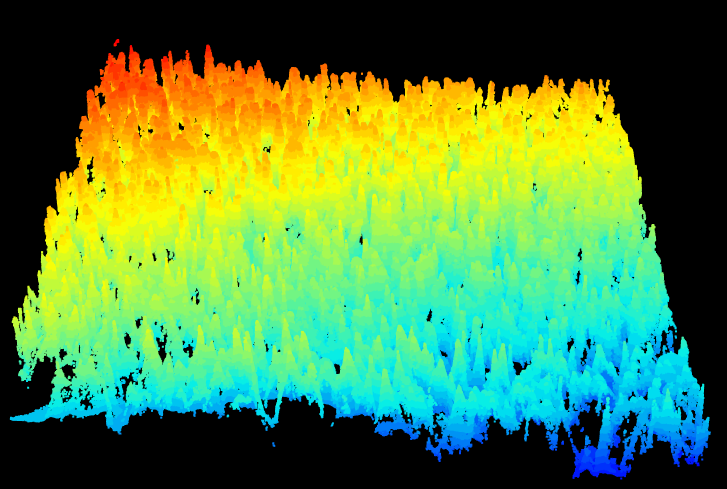


A point cloud is a three dimensional discrete set of points space. Each point can be identified using a set of three Cartesian coordinates (X, Y, and Z). The set of point cloud can represent a 3D landscape, or a shape, or an object. 

The workflow includes following steps:

1. Point cloud classification

2. Canopy height model

3. Tree tops delineation

4. Individual tree crown delineation


In [ ]:
# set working environment
wd = "/home/jovyan/data_forest_resiliency/UAS/input/input"
setwd(wd)


In [ ]:
#check the required libraries are available. If not install required libraries.

list.of.packages <- c("tidyverse","lidR","terra","raster","rgdal","ForestTools","RCSF","sp","sf","stars")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages)


In [ ]:
## Load the required libraries. We use several libraries that can help with data loading, reading spatial data including raster and point cloud data, 
## analyse those data, and to visualize and write the spatial data back into a desired location.
options("rgdal_show_exportToProj4_warnings"="none")

library(tidyverse)
library(lidR)
library(terra)
library(raster)
library(rgdal)
library(ForestTools)
library(RCSF)
library(sp)
library(sf)
library(stars)

#install.packages("Rcpp", repos="https://rcppcore.github.io/drat")


In [ ]:
# explore the raw data and load the raw data file names

file_list = dir(wd, pattern = ".las", full.names = FALSE, ignore.case = TRUE) 
names_to_cloud = substr(file_list, 1, nchar(file_list)-4) # truncate the file names only to get the name part eliminating the extension.


In [ ]:
#get the raw point cloud data from the data storage. 

cropped_dense_point_cloud_fname <- file.path(paste0(file_list[1])) # the number here to say data from which file in the list we want to load

dense_point_cloud <- lidR::readLAS(cropped_dense_point_cloud_fname)

summary(dense_point_cloud) # this will show the data structure and high level information within the point cloud file we loaded.




In [ ]:
#read digital surface model in raster format. Digital surface model here was created using proprietary software called Agisoft metashape. 
test_dsm = raster(file.path(paste0("cropped_dsm_new.tif")))

#crop the digital surface model (a raster file that contains surface elevation data)
#test_dsm = crop(main_dsm,dense_point_cloud)
plot(test_dsm, main="Digital Surface Model")

#writeRaster(x = test_dsm, filename = "cropped_dsm.tif", overwrite = TRUE)

In [ ]:
#assign variables and file saving location
site_name <- "NIWO"
flight_datetime <- "06-28-2022"

# directories to be created in this script
new_dir <- file.path("out_data", site_name, flight_datetime)

  if(!dir.exists(new_dir)) {
    dir.create(new_dir, recursive = TRUE)
  }


cropped_dtm_fname <- file.path("out_data", site_name,flight_datetime, paste0(names_to_cloud[1], "_dtm2.tif"))
cropped_chm_fname <- file.path("out_data", site_name,flight_datetime,paste0(names_to_cloud[1], "_chm2.tif"))
cropped_crowns_fname <- file.path("out_data", site_name, flight_datetime,paste0(names_to_cloud[1], "_crowns_cropped2.gpkg"))


# Point classification

In this section, we classify the points into ground and above ground points. To classify ground in this module we use " cloth simulation function" (https://r-lidar.github.io/lidRbook/gnd.html) algorithm. 

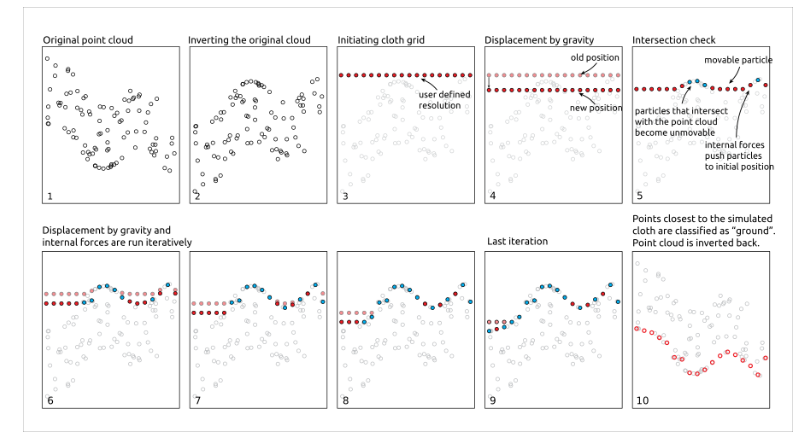

More information about the algorithm can be found https://r-lidar.github.io/lidRbook/gnd.html. The algorithm is first proposed by https://doi.org/10.3390/rs8060501. Then use ground points to generate digital terrain model. 

In [ ]:
dense_point_cloud[["X scale factor"]] = 0.001
dense_point_cloud[["Y scale factor"]] = 0.001


# To classify ground in this module we use " cloth simulation function" algorithm. More information about the algorithm can be found https://r-lidar.github.io/lidRbook/gnd.html. The algorithm is first proposed by https://doi.org/10.3390/rs8060501

classified_dense_point_cloud <- lidR::classify_ground(las = dense_point_cloud,
                                                      algorithm = csf(sloop_smooth = TRUE,
                                                                      class_threshold = 0.25,
                                                                      cloth_resolution = 0.50, # was 0.5 before,
                                                                      rigidness = 1,
                                                                      iterations = 500,
                                                                      time_step = 0.65))

bgplot3d(classified_dense_point_cloud)


# Digital terrain model (DTM)

The DTM represents the topography of the bare ground underneath the trees, grass or shrubs. In this module we use triangular irregular network (TIN) of ground point data to derive the ground surface. More information on the DTM deneration can be found at (https://r-lidar.github.io/lidRbook/gnd.html)

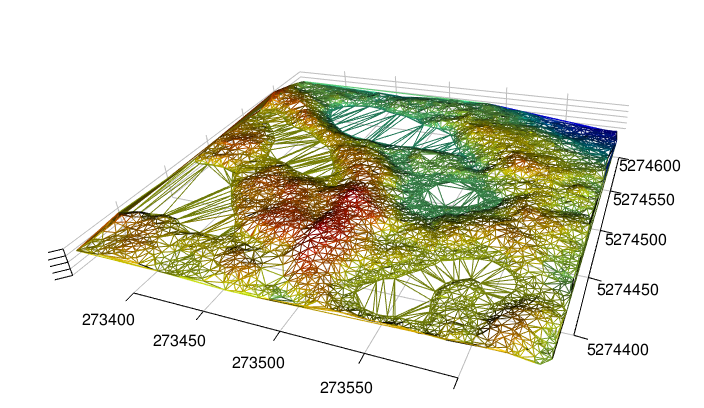

In [ ]:
# create canopy height model
dtm <- lidR::grid_terrain(las = classified_dense_point_cloud,
                          res = 0.10, # was 0.5 and 0.25 before
                          algorithm = tin())

#raster::writeRaster(x = dtm, filename = cropped_dtm_fname, overwrite = TRUE)
terra::writeRaster(x = dtm, filename = cropped_dtm_fname, overwrite = TRUE)

dtm_resamp <- raster::resample(x = dtm, y = test_dsm, method = "bilinear")

plot(dtm_resamp, main = "Digital terrain model")

# Canopy height model (CHM)

The CHM represents the heights of the trees, grass or shrubs (any structure above ground). This is simply the difefrence between the Digital terrain model (DTM) and Digital surface model (DSM).

In [ ]:
# generate canopy height model. canopy height model is a raster image where the values in pixel represents the canopy height at that pixel.
# The canopy height here is the difference between digital surface and the digital terrain models.
chm <- test_dsm - dtm_resamp
  
chm_smooth <- raster::focal(chm, w = matrix(1, 3, 3), mean)
chm_smooth[raster::getValues(chm_smooth) < 0] <- 0

terra::writeRaster(x = chm_smooth, filename = cropped_chm_fname, overwrite = TRUE)
plot(chm_smooth, main =  "Canopy height model")

# Tree top detection

Treetops are detected using a variable moving  window function (vwf). This function was implemented by [Popescu and Wynne (2004)](https://doi.org/10.3390/rs8060501). The moving window walks through the canopy height model and if a given cell is found to be the highest within the window, it is tagged as a treetop. The size of the window changes depending on the height of the center cell. First we define a function to define the dynamic window size. The inputs the function is the canopy height model and the output is the radius of the search window. 

In [ ]:
# detecting tree tops. In this section we navigate through each and every cell with a given moving window filter. The vwf or the variable window filter algorithm developed by Popescu and Wynne (2004). The size of the window changes based on the height of the cell on which it is centered.  from the cell that has the maximum height in the canopy height model and assign them to a certain tree. Thus it is important to define the variable size window at the first. Here we use 
# the equation "x^2*c + x*b + a" where x is the pixel height.  


chm = terra::rast(cropped_chm_fname)
max_chm = chm@ptr$range_max
print(max_chm)


a <- 0.3 # was 0.3
b <- 0.04 #0.04
c <- 0 #0

lin <- function(x){x^2*c + x*b + a} # window filter function to use in next step

ttops <- ForestTools::vwf(CHM = raster::raster(chm), 
                          winFun = lin,  # variable window defining function
                          minHeight = 0.5, # minimun height above ground to consider as a tree top
                          maxWinDiameter = 99) %>%  # max window size
   sf::st_as_sf()
    
ttop_crd = ttops %>%
    mutate(x = unlist(map(ttops$geom,1)),
           y = unlist(map(ttops$geom,2)))



plot(chm_smooth,main =  "Canopy height model")

points(ttop_crd$x,ttop_crd$y)


# Tree crown detection

In this section we outline the boundary of the canopy of the each tree we detected by the preveous step. For that, we use the mcws function that untilize the watershed algorthm. Watershed algorithms are frequently used in topographical analysis to outline drainage basins. Because, trees can vary by branches, bumps and other spurious treetops, the algorithm use an error mitigation method called marker-controlled segmentation (Beucher & Meyer, 1993)(https://www.taylorfrancis.com/chapters/edit/10.1201/9781482277234-12/morphological-approach-segmentation-watershed-transformation-beucher-meyer). 


In [ ]:
# tree crown delineation. In this section we segment tree crowns of each tree top we generated in the earlier step. We use "mcws" watershed algorithm.  

non_spatial_ttops <-
  ttops %>%
  dplyr::mutate(x = st_coordinates(.)[, 1],
                y = st_coordinates(.)[, 2]) %>%
  sf::st_drop_geometry()
  
#minHeight:  height above ground of the fringes of the lowest trees.

crowns <-
  ttops %>%
  ForestTools::mcws(CHM = raster::raster(chm), minHeight = 0.5, format = "raster") %>% # minheight was 1 m before
  setNames(nm = "treeID") %>%
  st_as_stars() %>%
  st_as_sf(merge = TRUE) %>%
  dplyr::left_join(non_spatial_ttops, by = "treeID") %>% 
  sf::st_make_valid()

for (i in 1:nrow(crowns)) {
  this_point <- sf::st_drop_geometry(crowns[i, ]) %>% sf::st_as_sf(coords = c("x", "y"), crs = sf::st_crs(crowns))
  crowns[i, "point_in_crown"] <- as.vector(sf::st_intersects(x = this_point, y = crowns[i, ], sparse = FALSE))
}

crowns <-
  crowns %>% 
  dplyr::filter(point_in_crown) %>% 
  dplyr::select(-point_in_crown)

if(!file.exists(cropped_crowns_fname)) {
  sf::st_write(obj = crowns, dsn = cropped_crowns_fname, delete_dsn = TRUE)
}


plot(chm,main =  "Canopy Crwon")
plot(crowns$geometry, add=TRUE)